## 1. Installing and importing necessary packages

In [ ]:
pip install scanpy 
# for installing package, you should make seperate cells for each installation

In [ ]:
pip install pandas 

In [ ]:
pip install numpy

In [ ]:
pip install matplotlib 

In [ ]:
pip install scvi-tools

In [ ]:
pip install seaborn

In [ ]:
pip install scipy

In [ ]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import scvi-tools as scvi
import seaborn

## 2. Checking imported packages and saving data 

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.4.3 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
results_file = 'write/dataset_name.h5ad'  

## 3. Parsing datasets and checking its composition

In [4]:
adata=sc.read_csv("Path_for_your_dataframe.csv")
# reading different types of rawdata requires to input different command

In [11]:
adata.var_names_make_unique()

In [12]:
adata

AnnData object with n_obs × n_vars = 822 × 14878

In [ ]:
adata.X.shape

## 4. Highest expression gene calculation and removing unnecessary genes and cells

normalizing counts per cell
    finished (0:00:00)


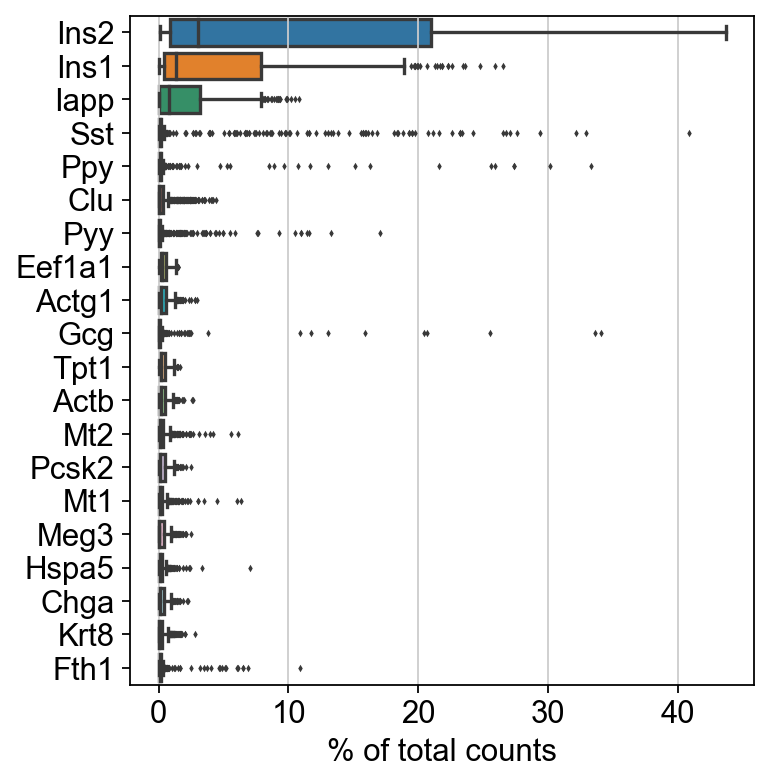

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
#You should decide the number according to the characteristic of your dataset and purpose of analysis

filtered out 1851 genes that are detected in less than 3 cells


In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#sometimes your dataset might have 'MT-' or "Mt-" for mitrochondrial gene name, so you should always check them

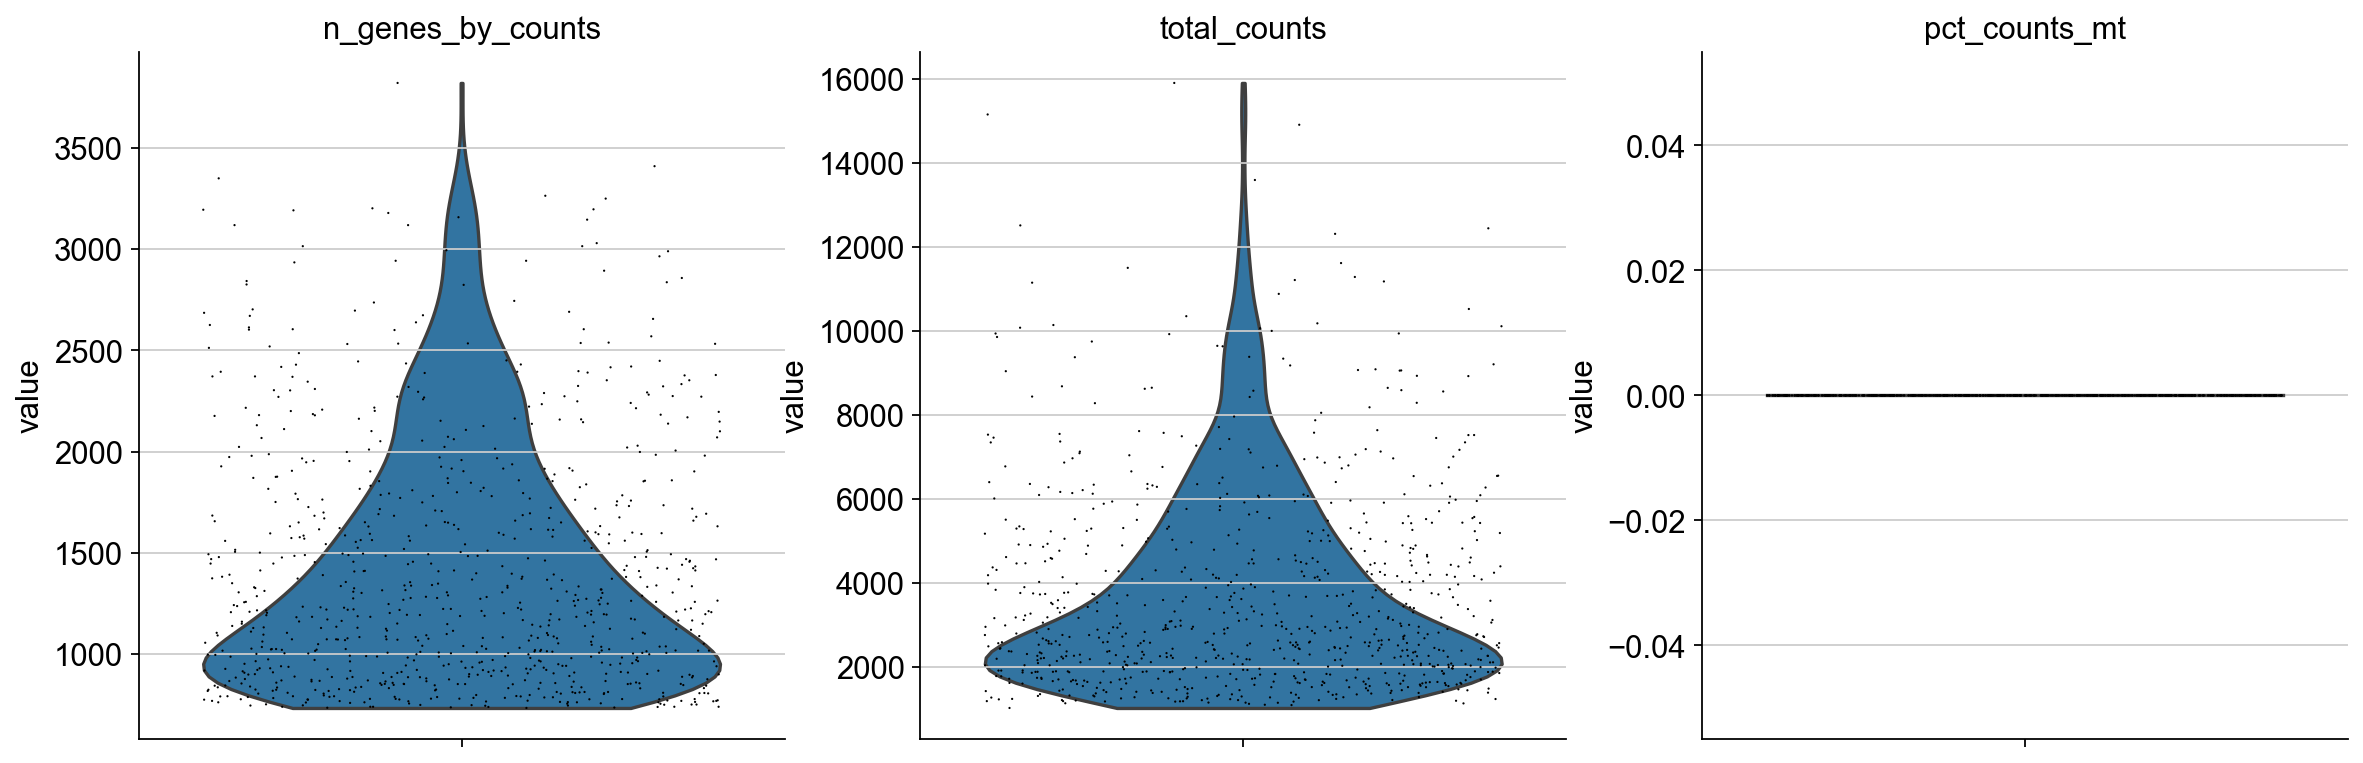

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

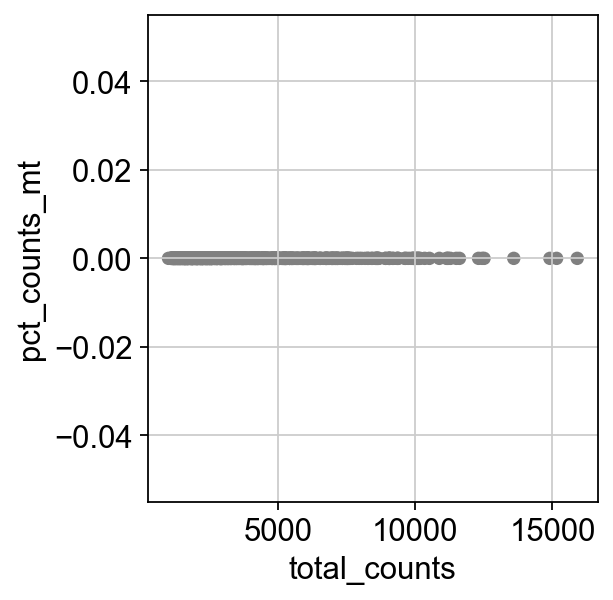

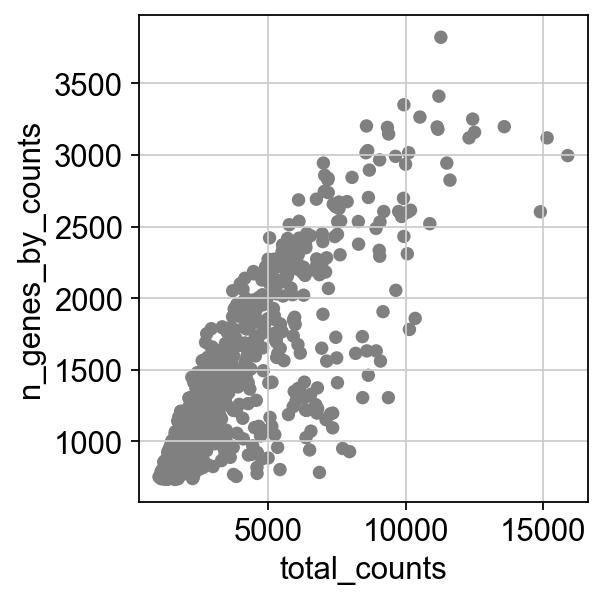

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [18]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
#Again, this threshold should be settled by your choice. Especially when you are dealing with dataframe from embryonic days 

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
#normalizing target should be considered by yourself. 1e4 is the most common set

normalizing counts per cell
    finished (0:00:00)


C:\Users\paper\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


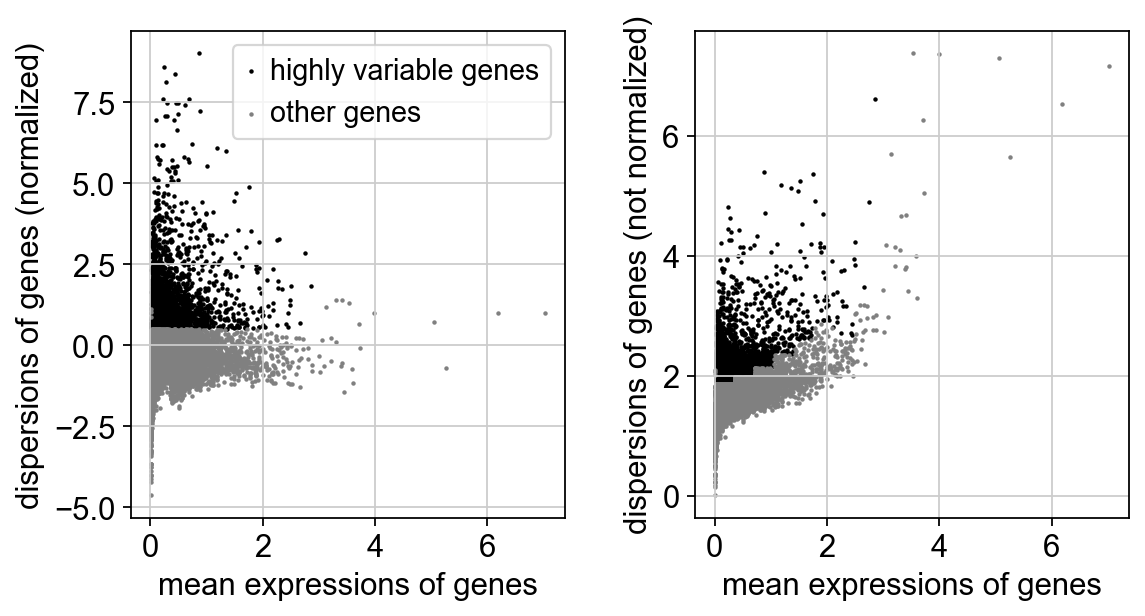

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata.raw = adata

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:04)


In [27]:
sc.pp.scale(adata, max_value=10)

## 5. Calculating PCA and neighbors & Clustering 

In [28]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


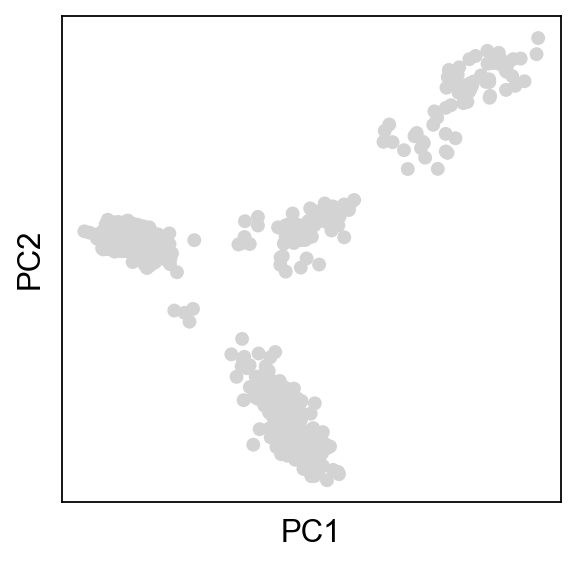

In [29]:
sc.pl.pca(adata)

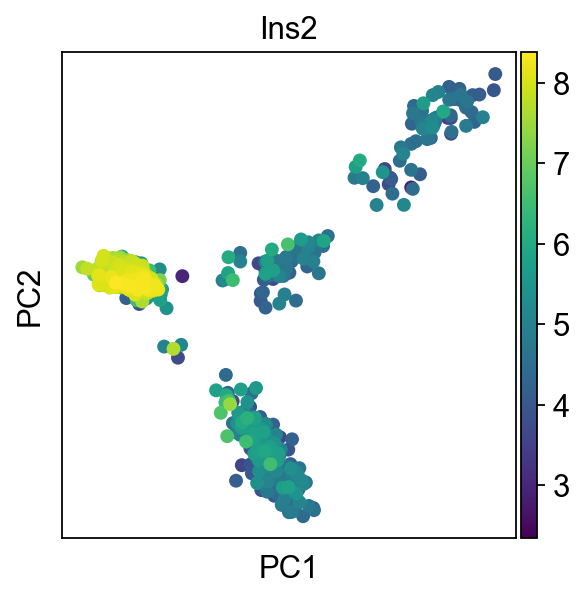

In [30]:
sc.pl.pca(adata, color='Ins2')

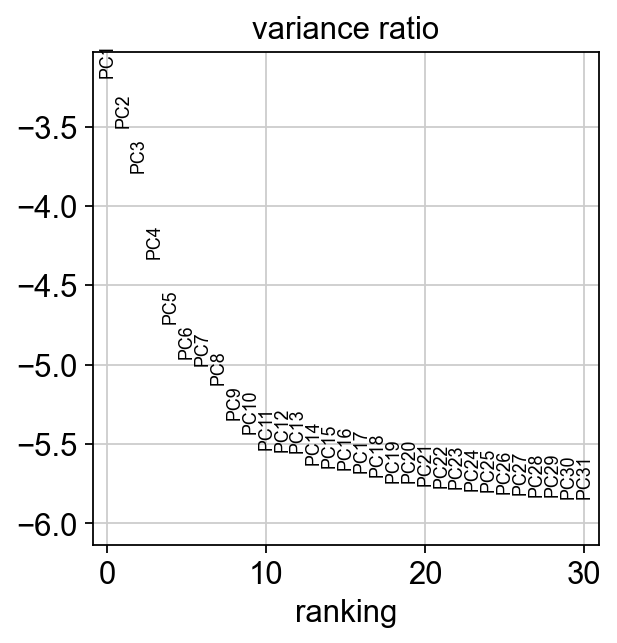

In [31]:
sc.pl.pca_variance_ratio(adata, log=True)

In [33]:
adata.write(results_file)

In [34]:
adata

AnnData object with n_obs × n_vars = 768 × 2919
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [35]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [37]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


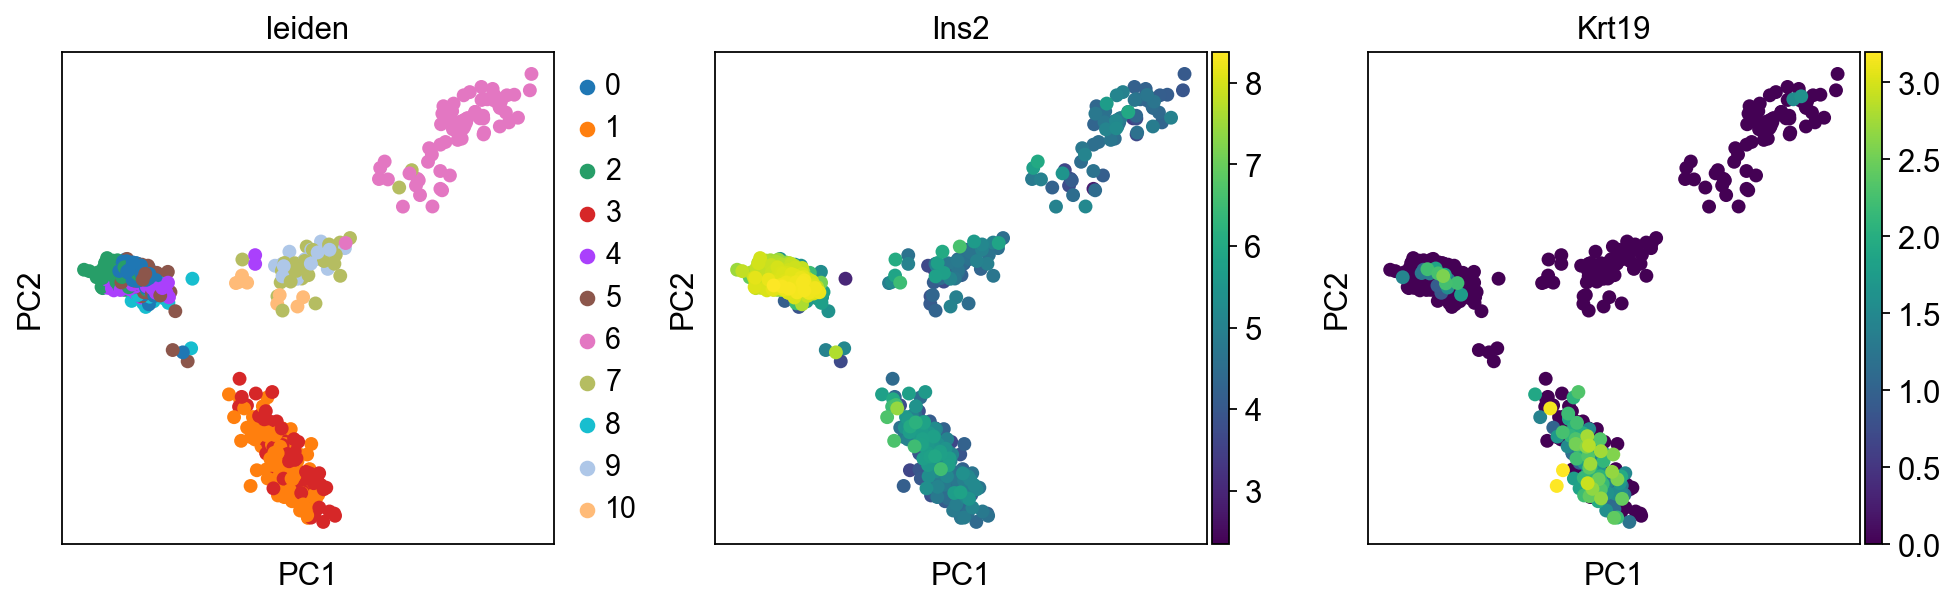

In [39]:
sc.pl.pca(adata,color=['leiden', 'Ins2', 'Krt19'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


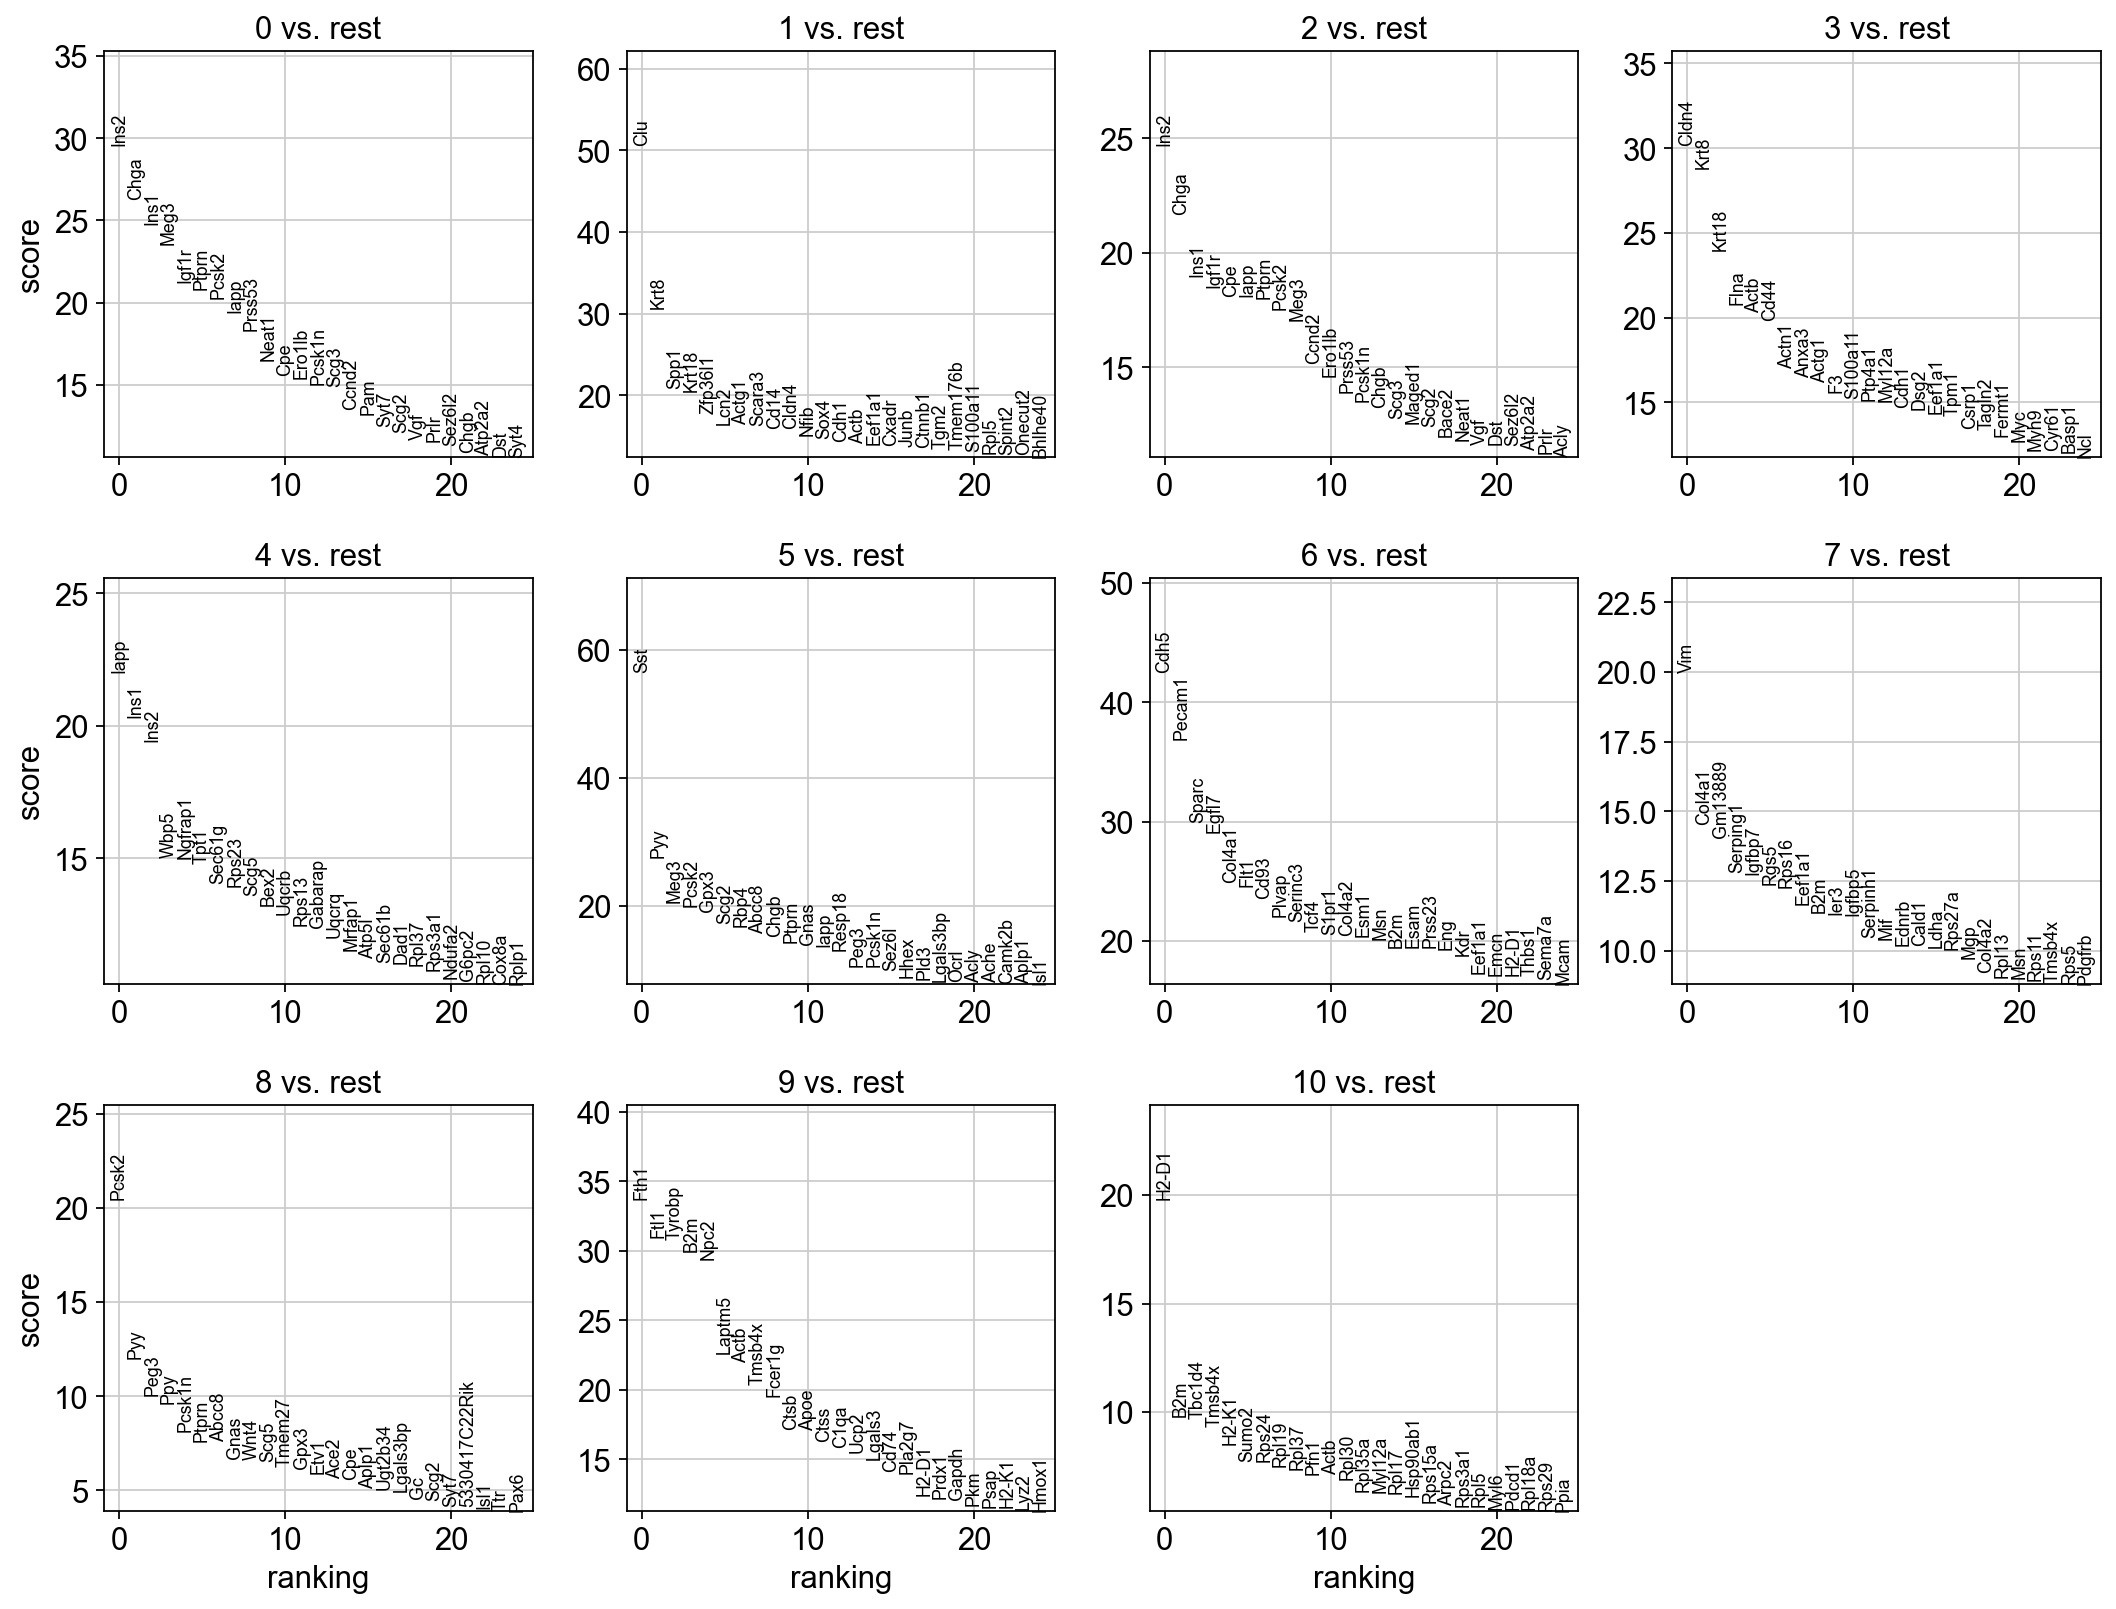

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [41]:
sc.settings.verbosity = 2

ranking genes
    finished (0:00:00)


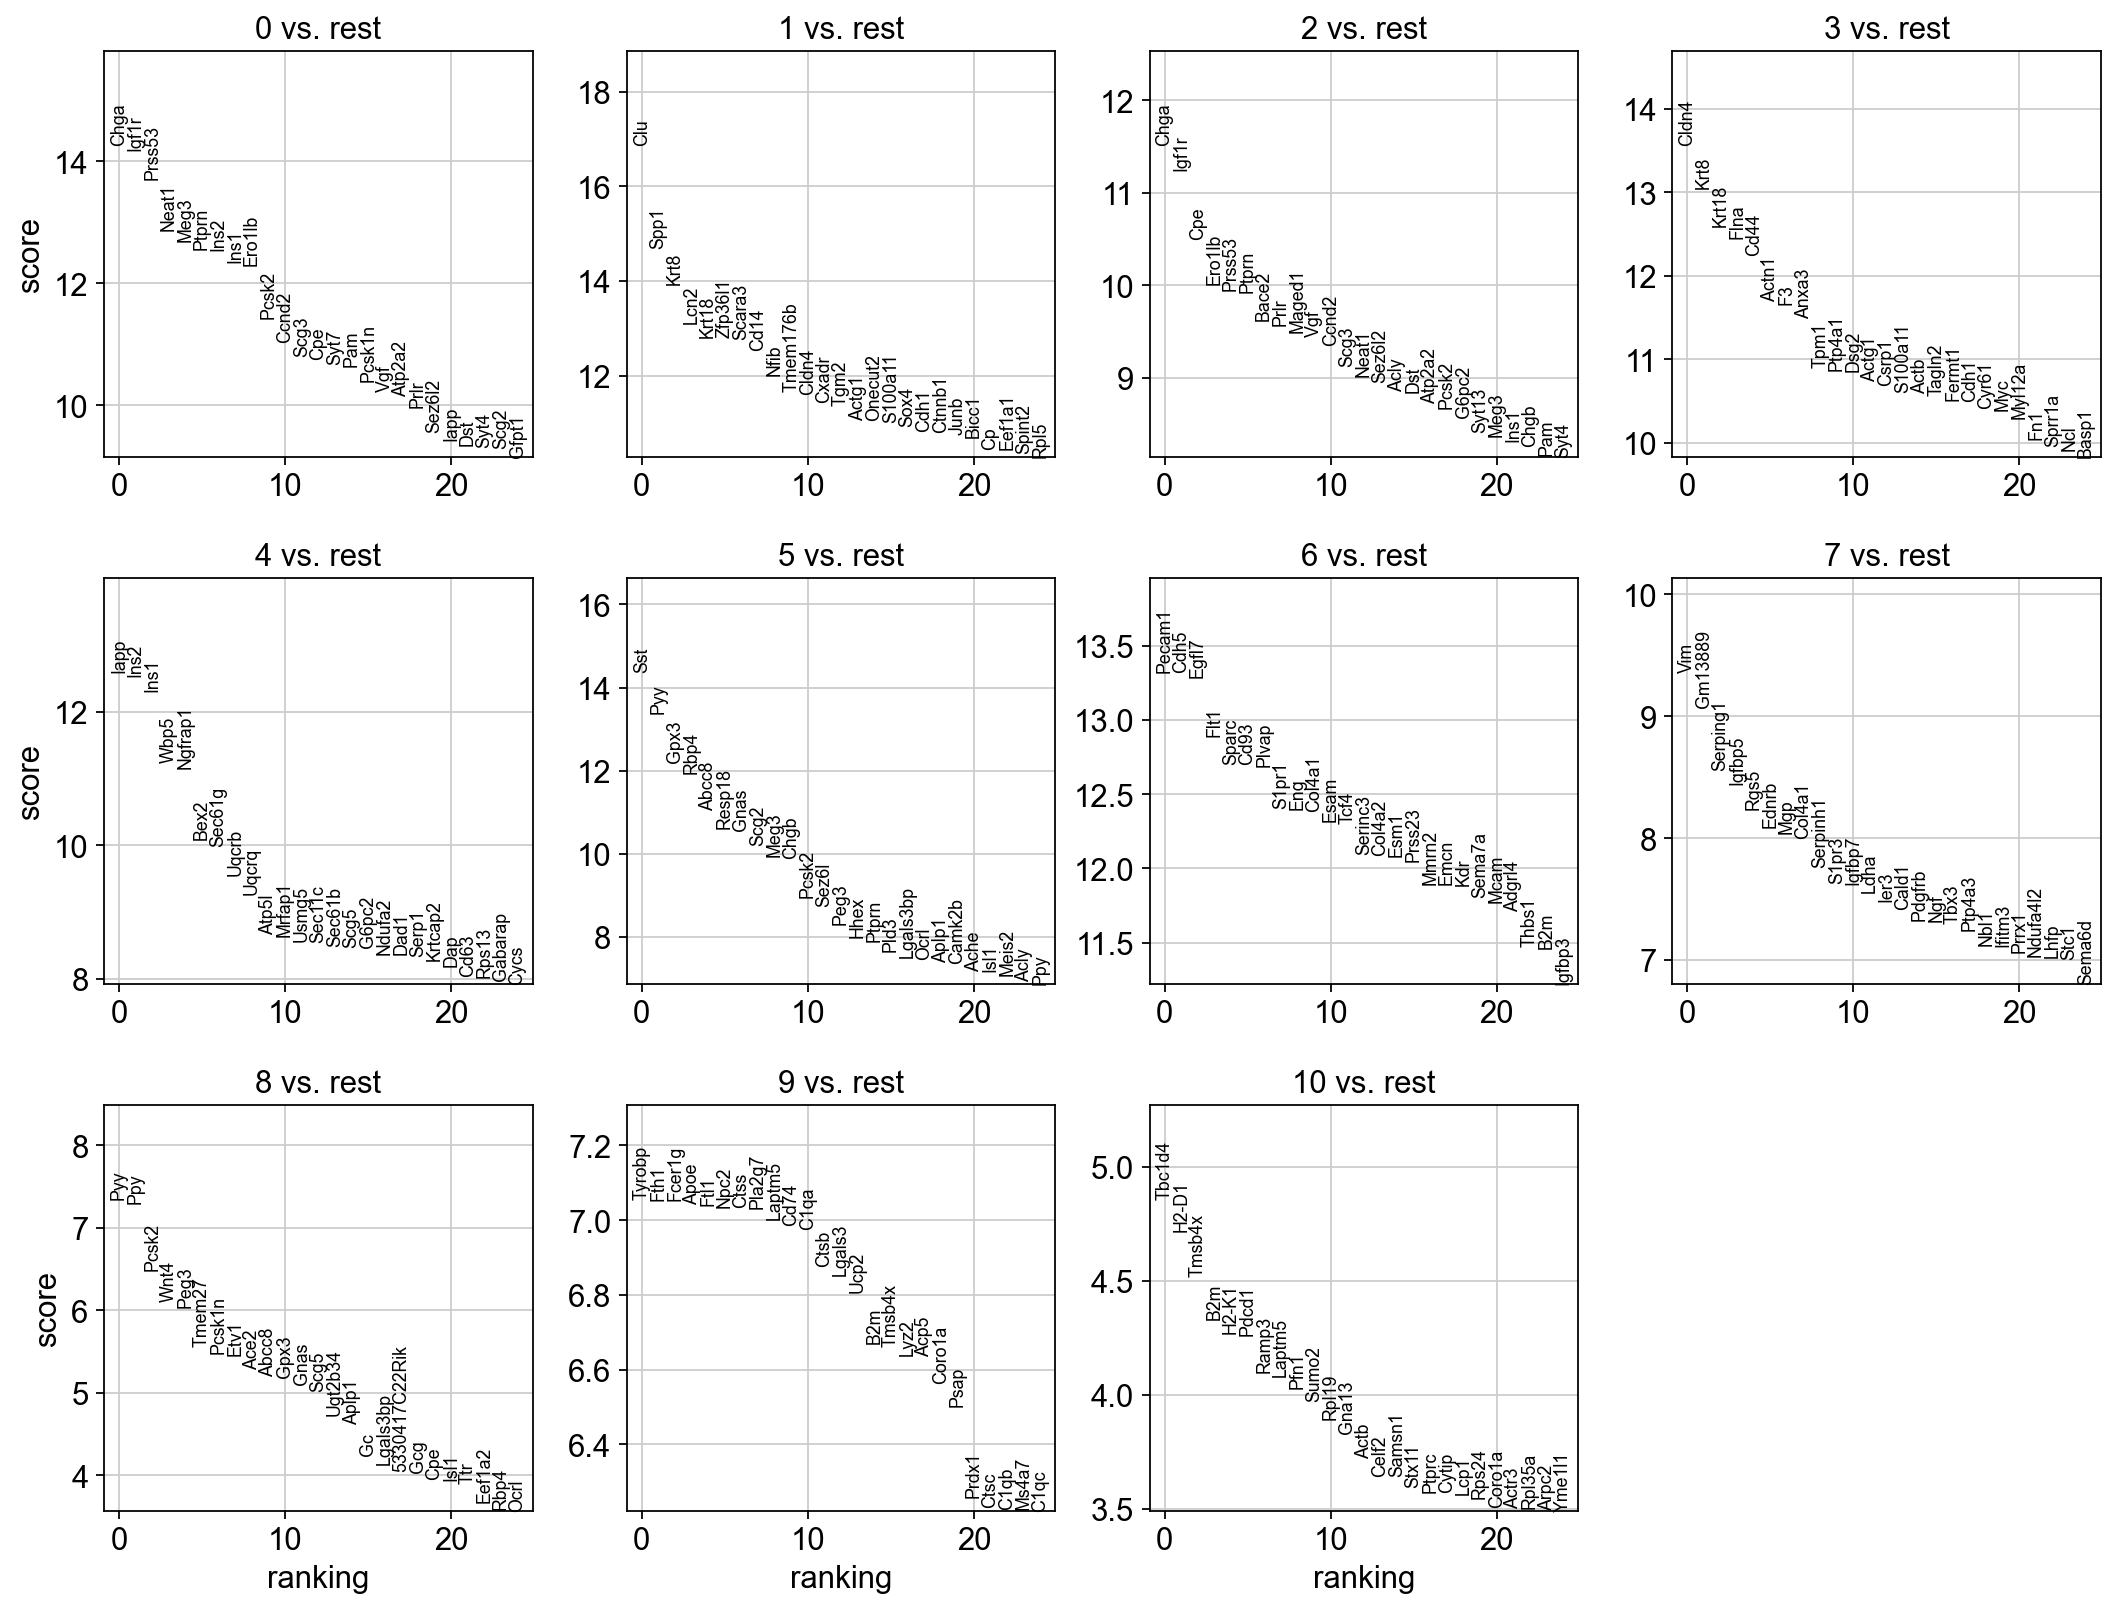

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
adata.write(results_file)

ranking genes
    finished (0:00:03)


C:\Users\paper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


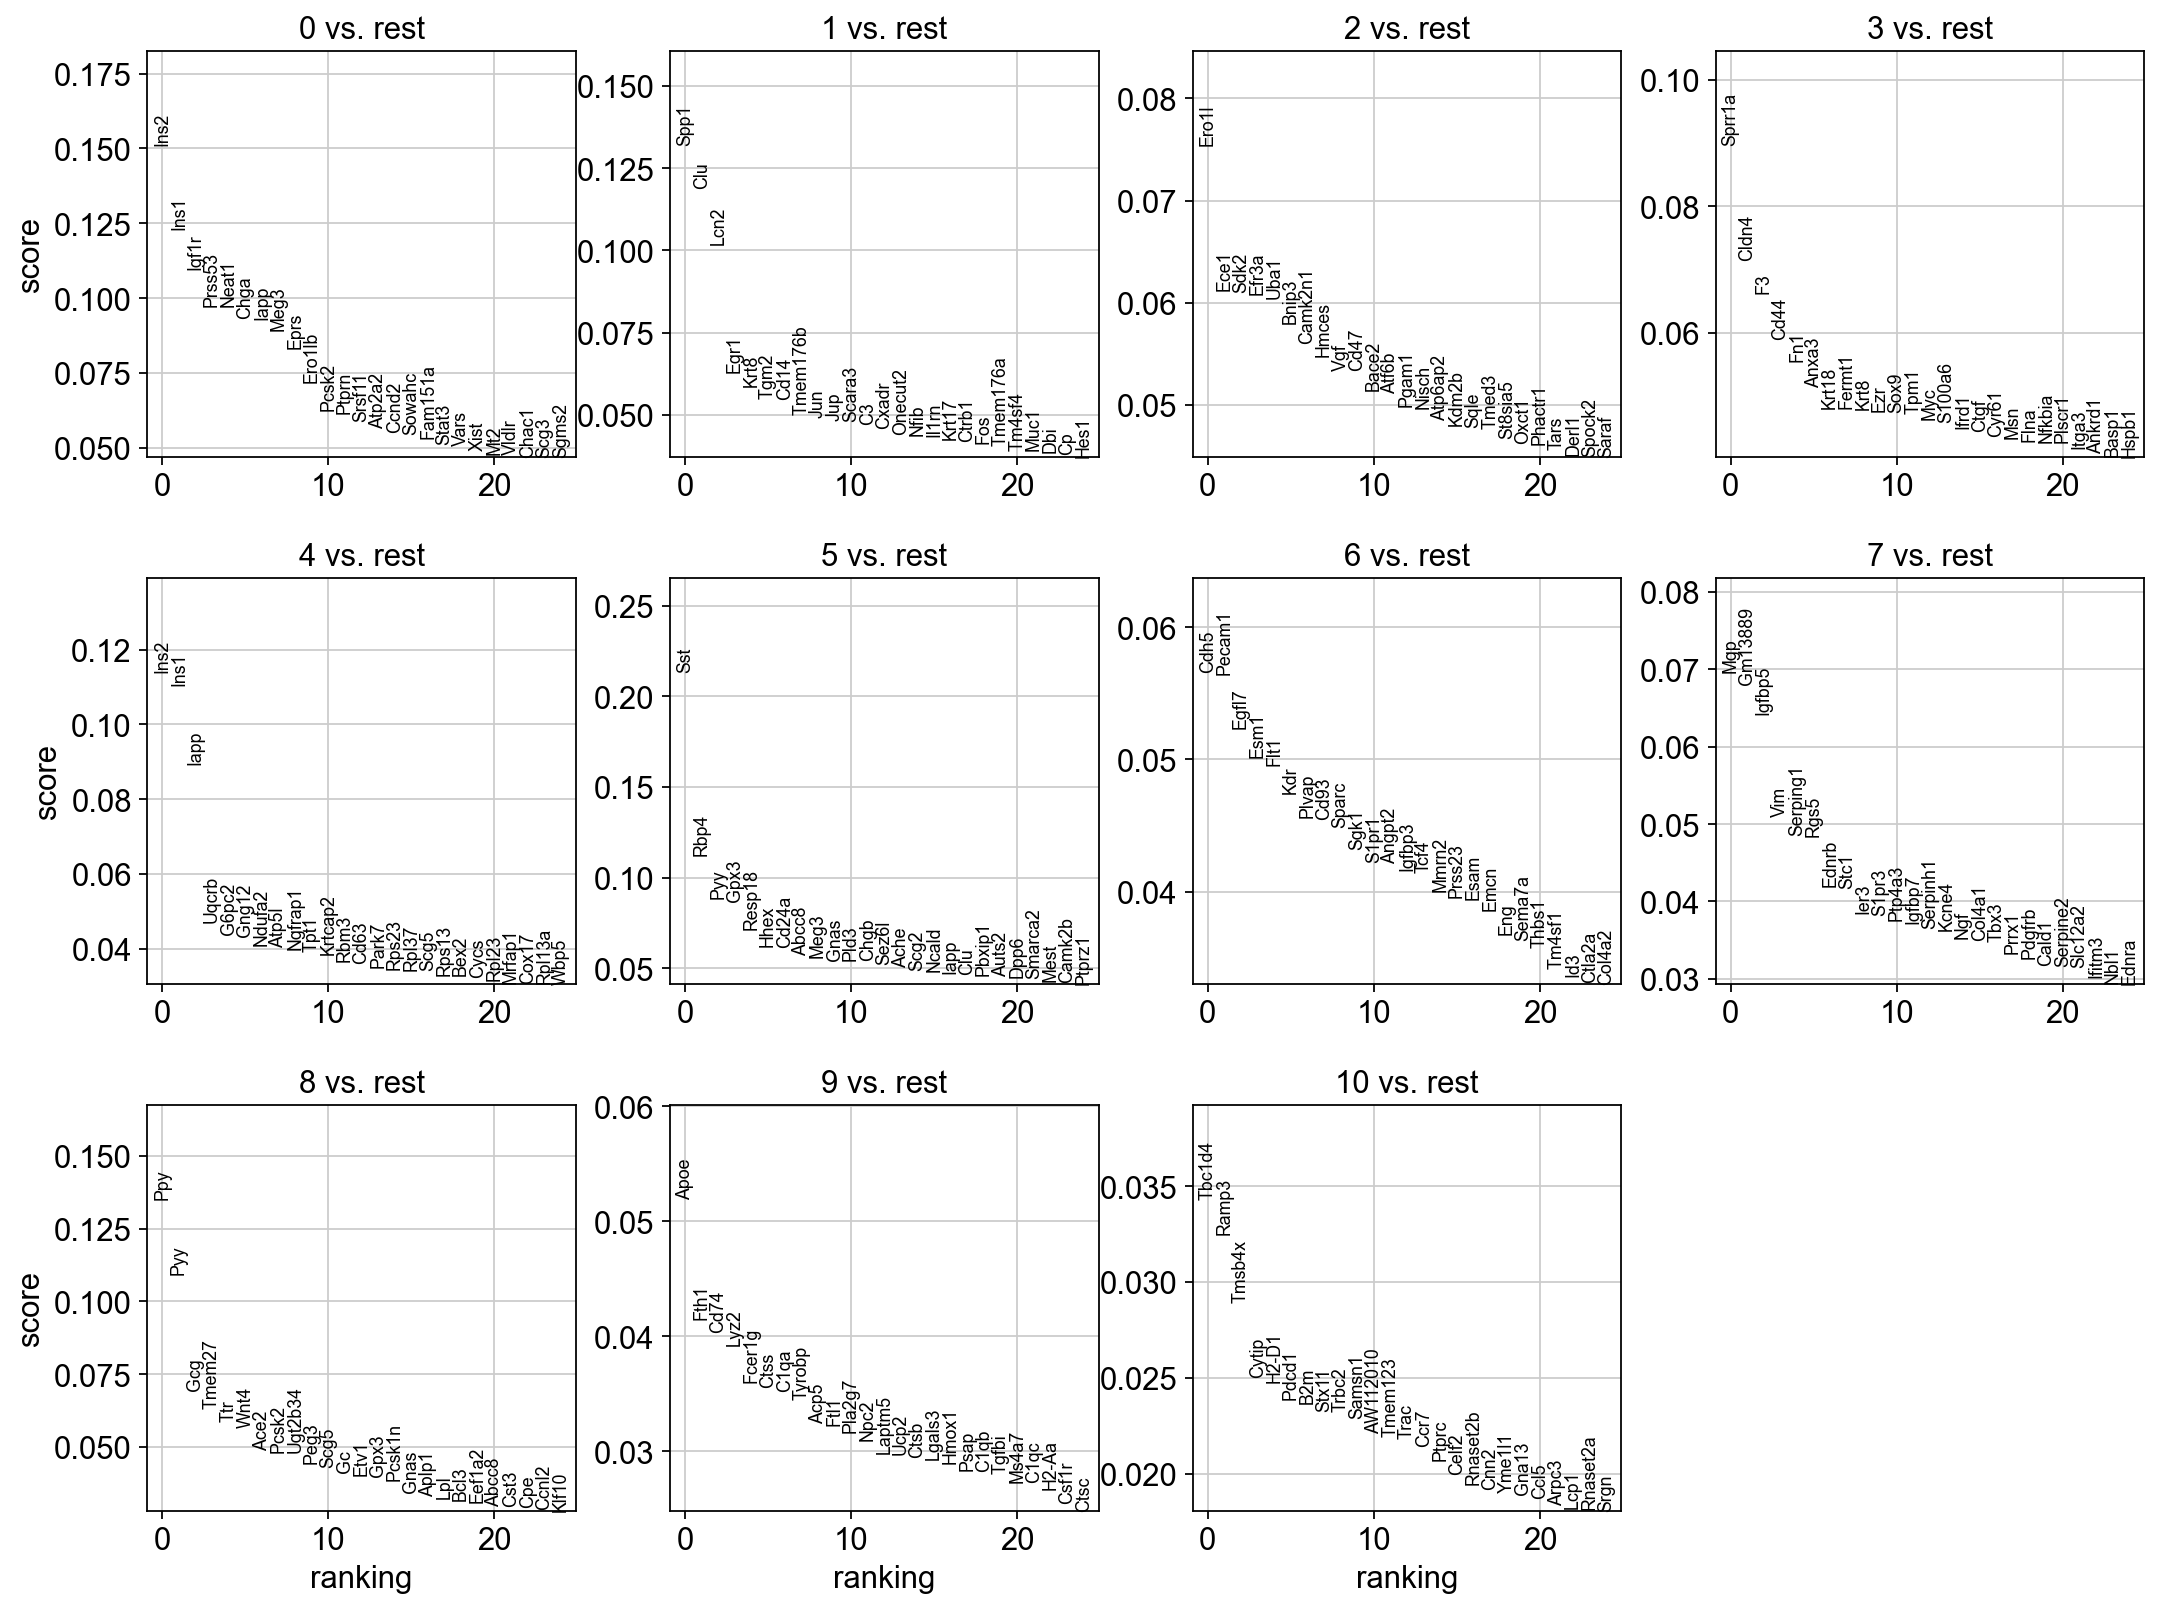

In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [45]:
adata = sc.read(results_file)

In [48]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0      1       2      3        4      5       6         7      8  \
0    Chga    Clu    Chga  Cldn4     Iapp    Sst  Pecam1       Vim    Pyy   
1   Igf1r   Spp1   Igf1r   Krt8     Ins2    Pyy    Cdh5   Gm13889    Ppy   
2  Prss53   Krt8     Cpe  Krt18     Ins1   Gpx3   Egfl7  Serping1  Pcsk2   
3   Neat1   Lcn2  Ero1lb   Flna     Wbp5   Rbp4    Flt1    Igfbp5   Wnt4   
4    Meg3  Krt18  Prss53   Cd44  Ngfrap1  Abcc8   Sparc      Rgs5   Peg3   

        9      10  
0  Tyrobp  Tbc1d4  
1    Fth1   H2-D1  
2  Fcer1g  Tmsb4x  
3    Apoe     B2m  
4    Ftl1   H2-K1

In [49]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p    1_n           1_p     2_n           2_p    3_n  \
0    Chga  3.622523e-46    Clu  7.128669e-64    Chga  1.059172e-30  Cldn4   
1   Igf1r  1.148680e-45   Spp1  7.541372e-49   Igf1r  2.542136e-29   Krt8   
2  Prss53  8.713346e-43   Krt8  4.293726e-44     Cpe  8.505010e-26  Krt18   
3   Neat1  6.030512e-38   Lcn2  3.266617e-39  Ero1lb  1.311743e-23   Flna   
4    Meg3  7.265063e-37  Krt18  1.199044e-37  Prss53  2.444836e-23   Cd44   

            3_p      4_n           4_p  ...     6_n           6_p       7_n  \
0  6.238463e-42     Iapp  2.179228e-36  ...  Pecam1  1.691885e-40       Vim   
1  6.061746e-39     Ins2  4.509863e-36  ...    Cdh5  1.765285e-40   Gm13889   
2  2.343185e-36     Ins1  7.795990e-35  ...   Egfl7  2.687470e-40  Serping1   
3  1.397221e-35     Wbp5  2.524454e-29  ...    Flt1  5.243640e-38    Igfbp5   
4  1.703002e-34  Ngfrap1  6.257415e-29  ...   Sparc  5.676172e-37      Rgs5   

            7_p    8_n           8_p     9_n           9_p    10_n      10_p  
0  7.613544e-21    Pyy  1.995872e-13  Tyrobp  1.697032e-12  Tbc1d4  0.000001  
1  1.158709e-19    Ppy  2.838705e-13    Fth1  1.724238e-12   H2-D1  0.000002  
2  1.128894e-17  Pcsk2  8.653999e-11  Fcer1g  1.738001e-12  Tmsb4x  0.000006  
3  3.085745e-17   Wnt4  1.020981e-09    Apoe  1.866815e-12     B2m  0.000015  
4  1.740368e-16   Peg3  1.557079e-09    Ftl1  1.911799e-12   H2-K1  0.000019  

[5 rows x 22 columns]

In [50]:
from matplotlib.pyplot import rc_context

In [51]:
adata

AnnData object with n_obs × n_vars = 768 × 2919
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

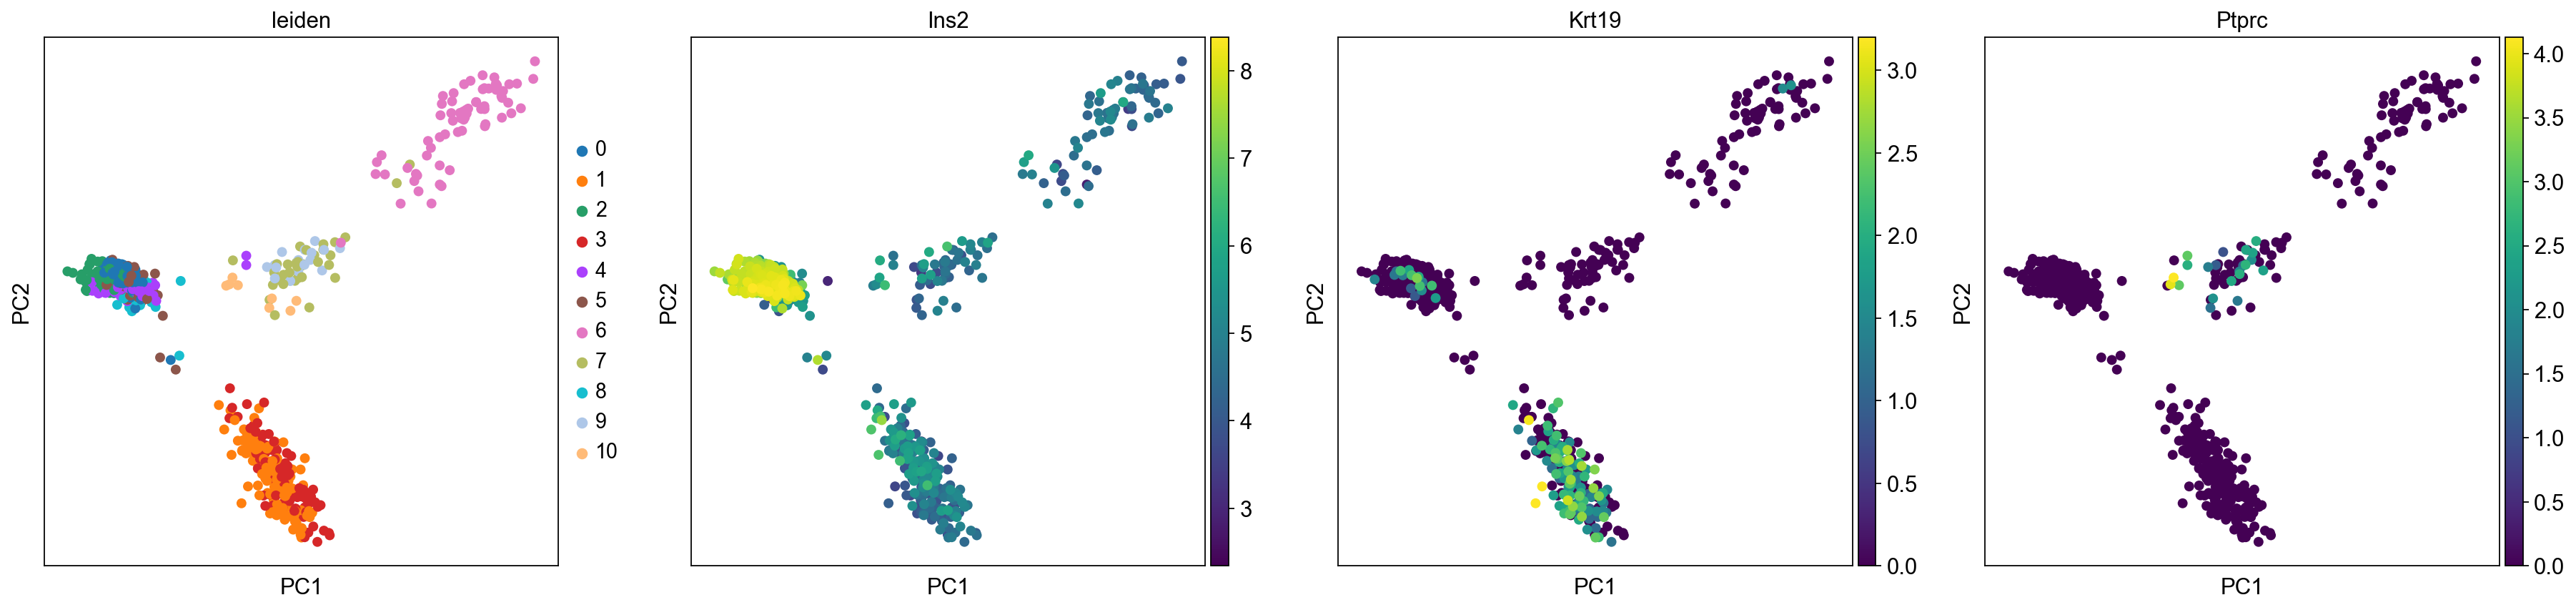

In [54]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.pca(adata, color=['leiden', 'Ins2', 'Krt19', 'Ptprc'])

In [55]:
sc.tl.leiden(adata, key_added='clusters', resolution=0.5)

running Leiden clustering
    finished (0:00:00)


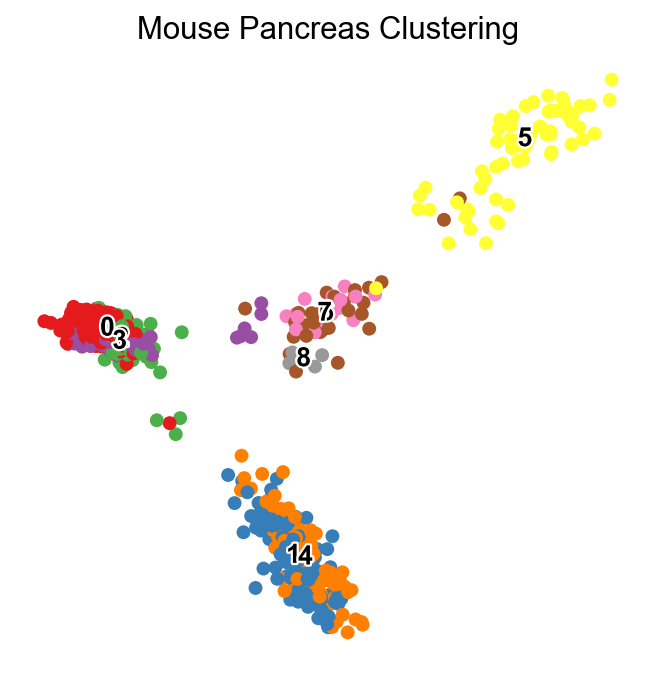

In [59]:
with rc_context({'figure.figsize':(5,5)}) : 
    sc.pl.pca(adata, color='clusters', add_outline=False, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='Mouse Pancreas Clustering', palette='Set1')

## 

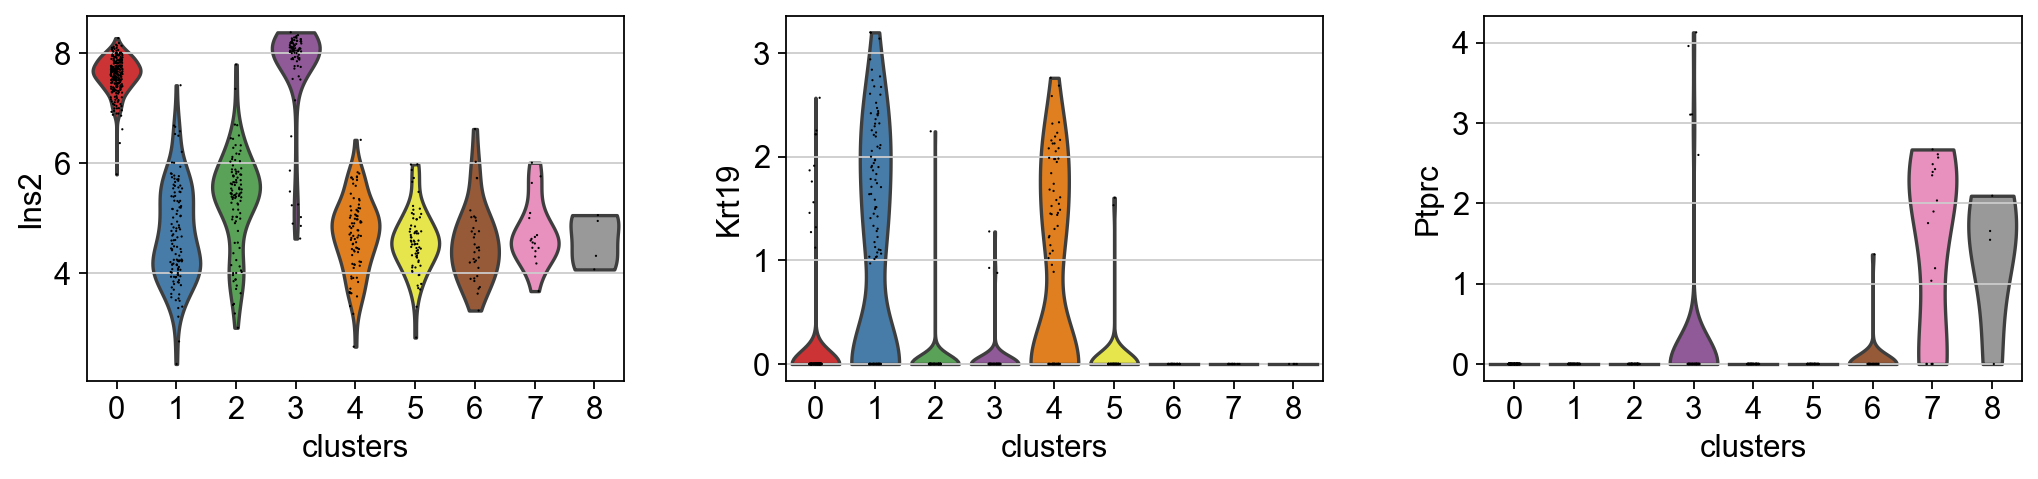

In [63]:
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(adata, ['Ins2', 'Krt19', 'Ptprc'], groupby='clusters' )

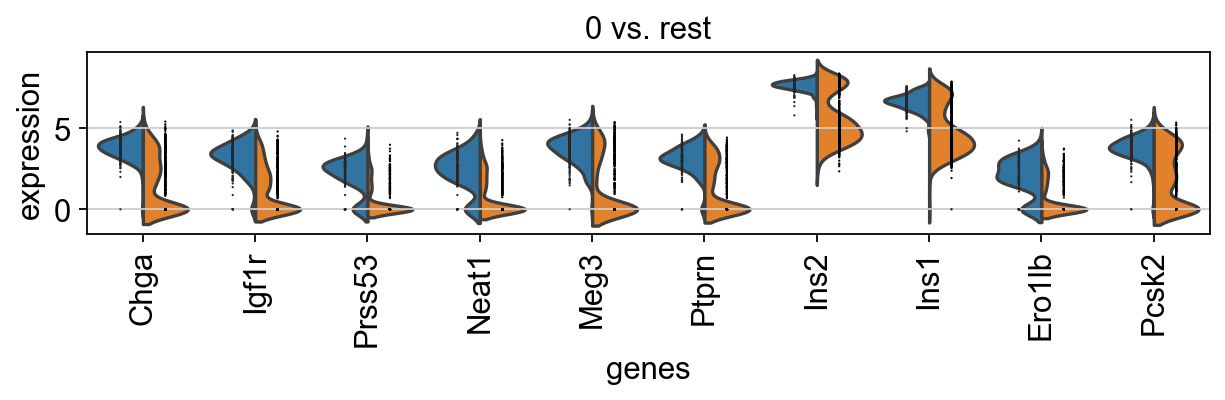

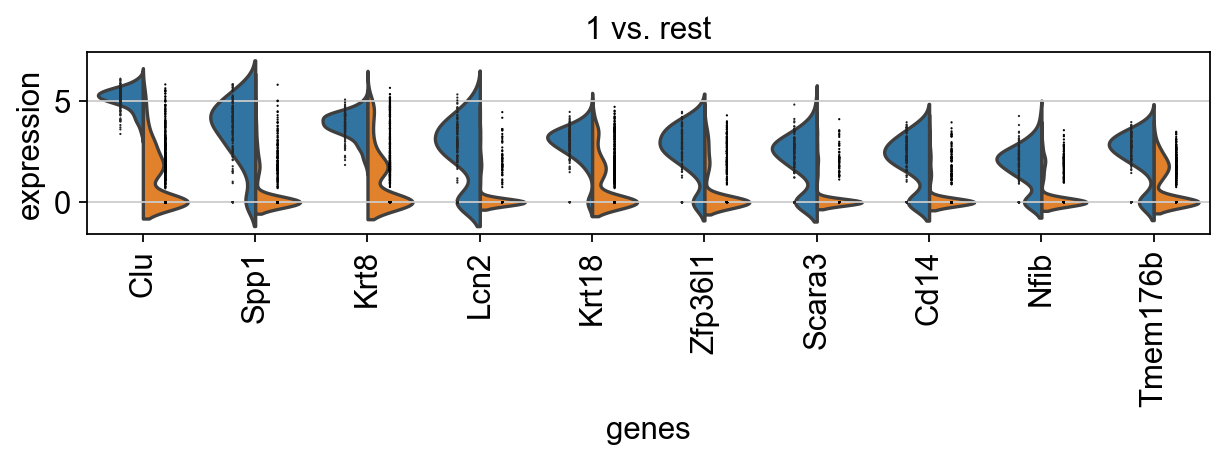

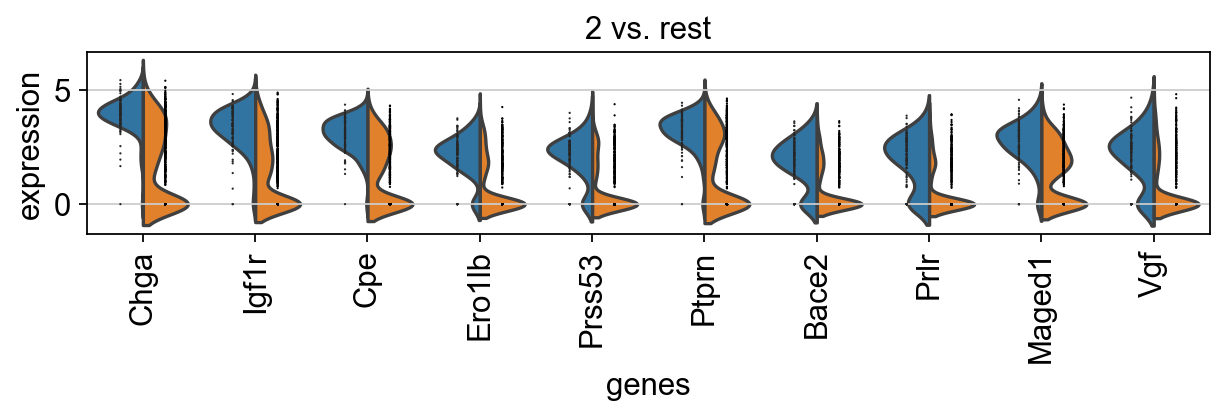

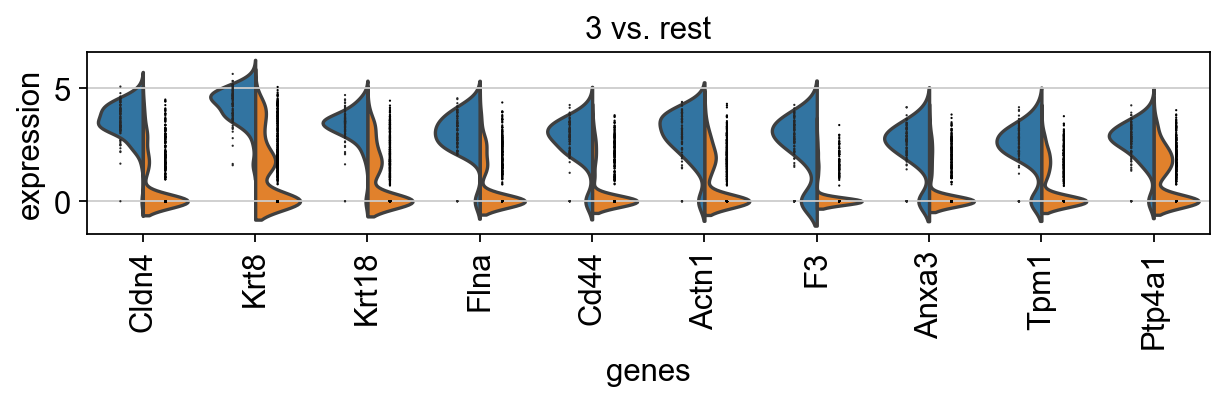

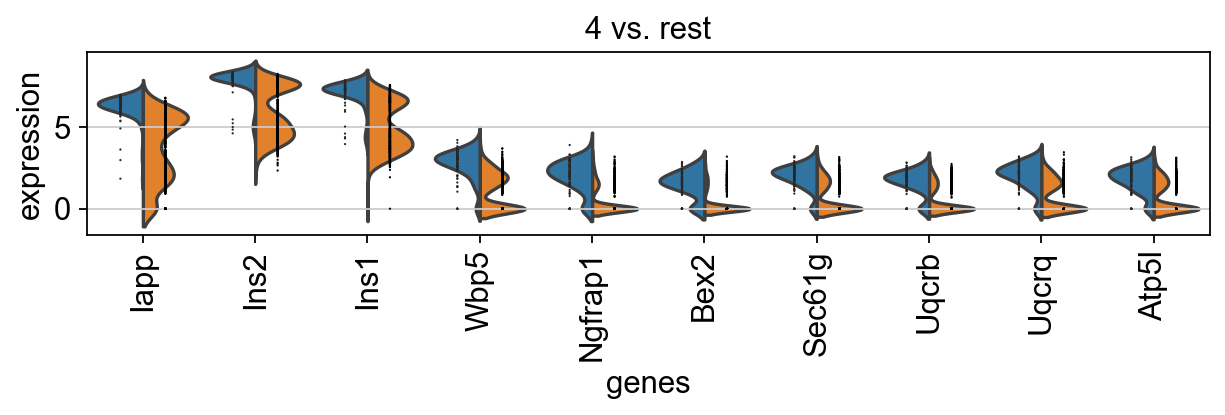

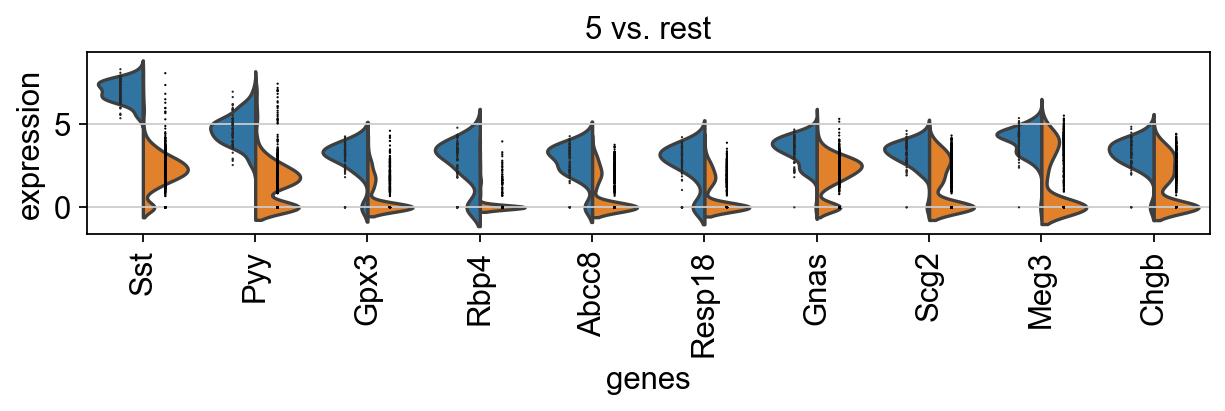

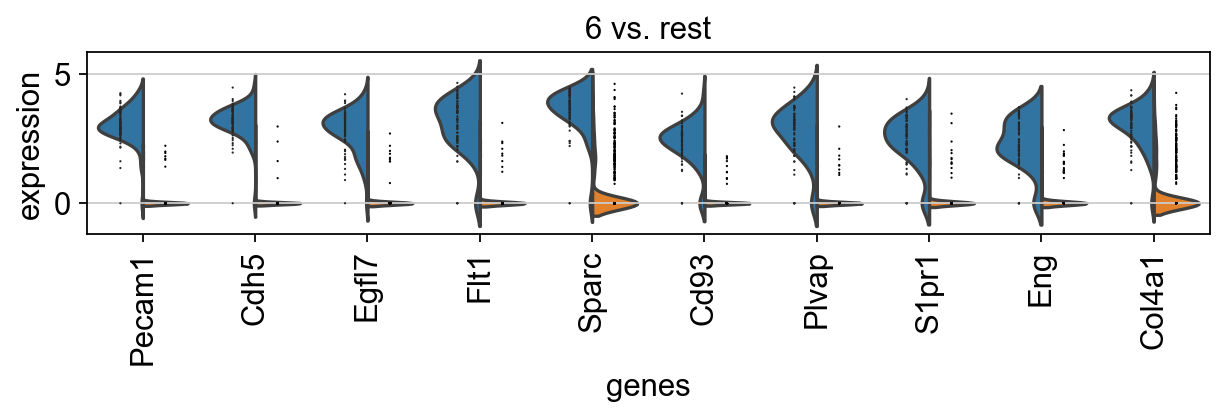

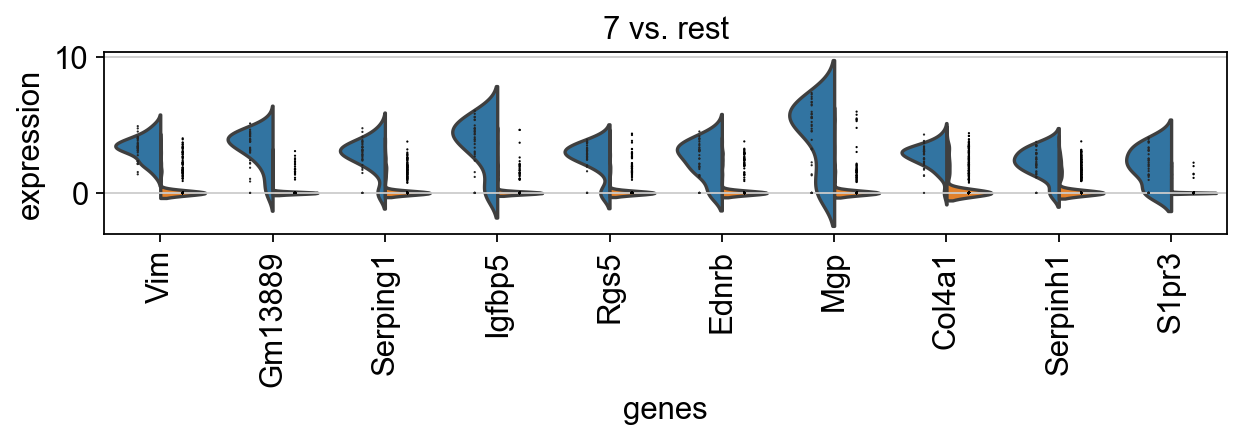

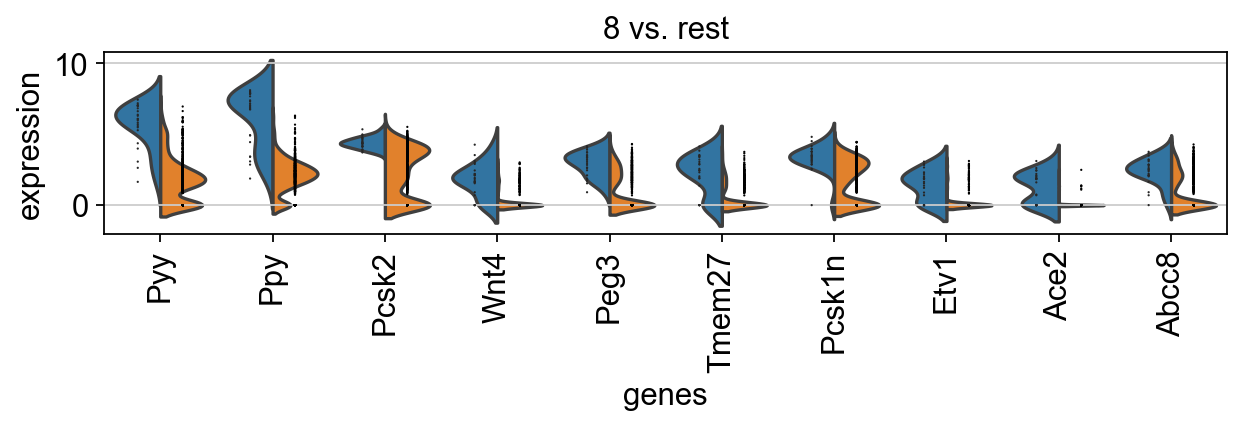

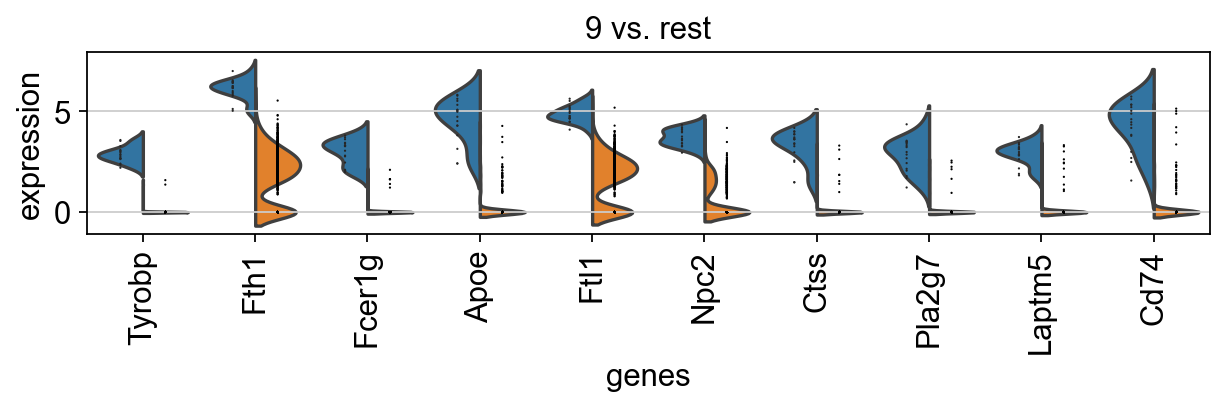

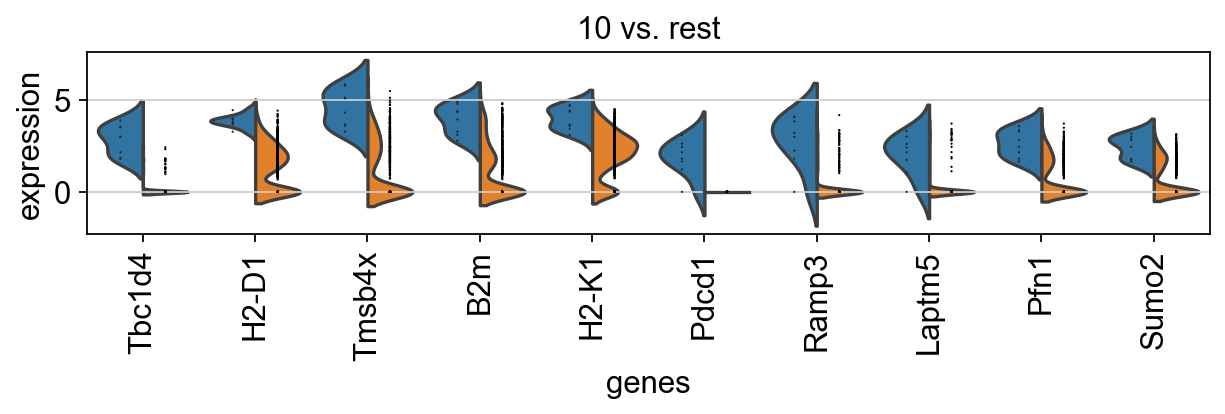

In [64]:
with rc_context({'figure.figsize': (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(adata, n_genes=10, jitter=False)